In [1]:
from fastbook import *
from fastai.vision import *

In [2]:
IMG_HEIGHT, IMG_WIDTH = 1400, 2100

In [3]:
clouds_path = URLs.path('clouds')

In [4]:
clouds_path.ls()

(#5) [Path('/storage/archive/clouds/sample_submission.csv'),Path('/storage/archive/clouds/test_images'),Path('/storage/archive/clouds/understanding_cloud_organization.zip'),Path('/storage/archive/clouds/train_images'),Path('/storage/archive/clouds/train.csv')]

In [5]:
train_images_path = clouds_path/'train_images'
train_images_path

Path('/storage/archive/clouds/train_images')

In [6]:
len(train_images_path.ls())

5546

In [7]:
len(Path('/storage/archive/clouds/test_images').ls())

3698

In [8]:
df_train = pd.read_csv(Path(clouds_path/'train.csv'))

In [9]:
df_train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 937 277518 937 278918 937 280318 937 281718 937 283118 937 284518 937 285918 937 287318 937 288718 937 290118 937 291518 937 292918 937 294318 937 295718 937 297118 937 298518 937 299918 937 301318 937 302718 937 304118 937 305518 937 306918 937 308318 937 309718 937 311118 937 312518 937 313918 937 315318 937 316718 937 318118 937 319518 937 320918 937 322318 937 323718 937 325118 937 326518 937 327918 937 329318 937 330718 937 332118 937 333518 937 334918 937 336318 937 337718 937 339118 937 34...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 1365365 1002 1366765 1002 1368165 1002 1369565 1002 1370965 1002 1372365 1002 1373765 1002 1375165 1002 1376565 1002 1377965 1002 1379365 1002 1380765 1002 1382165 1002 1383565 1002 1384965 1002 1386365 1002 1387765 1002 1389165 1002 1390565 1002 1391965 1002 1393365 1002 1394765 1002 1396165 1002 1397565 1002 1398965 1002 1400365 1002 1401765 1002 1403165 1002 1404565 1002 1405965 1002 1407365 1002 1408765 1002 1410165 1002 1411565 1002 1412965 1002 1414365 1002 1415765 1002 1417165 1002 1418565 100...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 239410 881 240810 881 242210 881 243610 881 245010 881 246410 881 247810 881 249210 881 250610 881 252010 881 253410 881 254810 881 256210 881 257610 881 259010 881 260410 881 261810 881 263210 881 264610 881 266010 881 267410 881 268810 881 270210 881 271610 881 273010 881 274410 881 275810 881 277210 881 278610 881 280010 881 281410 881 282810 881 284210 881 285610 881 287010 881 288410 881 289810 881 291210 881 292610 881 294010 881 295410 881 296810 881 298210 881 299610 881 301010 881 302410 881 303810 881 305210 881 306610 881 308010 881 30...


In [10]:
df_train.shape

(22184, 2)

In [11]:
df_train_fish = df_train[df_train['Image_Label'].apply(lambda x: 'Fish' in x)]

In [12]:
df_train_fish.shape

(5546, 2)

### Build DataBlock

In [15]:
def rle2mask(encoded_pixels):
    mask = torch.zeros(IMG_HEIGHT * IMG_WIDTH, dtype=torch.uint8)
    encoded_pixels = encoded_pixels.split()
    
    # - 1 if for converting one-indexed to zero-indexed pixels
    start_pixles = [int(encoded_pixels[i]) - 1 for i in range(0, len(encoded_pixels), 2)]
    lengths = [int(encoded_pixels[i]) for i in range(1, len(encoded_pixels), 2)]
    
    for start_px, length in zip(start_pixles, lengths):
        mask[start_px:start_px + length] = 1
    
    return mask.reshape((IMG_WIDTH, IMG_HEIGHT)).T

In [16]:
def get_x(row):
    fname = row['Image_Label'].split('_')[0]
    return train_images_path/fname

In [17]:
def get_y(row):
    encoded_pixels = str(row['EncodedPixels'])
    if encoded_pixels =='nan':
        return torch.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=torch.uint8)
    return rle2mask(encoded_pixels)

In [18]:
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes = ['no clouds', 'Fish'])),
    get_x=get_x, get_y=get_y,
    item_tfms = RandomResizedCrop(128, min_scale=0.35),
)

In [19]:
dblock.summary(df_train_fish)

Setting-up type transforms pipelines
0      0011165.jpg_Fish   
4      002be4f.jpg_Fish   
8      0031ae9.jpg_Fish   
12     0035239.jpg_Fish   
16     003994e.jpg_Fish   
...                 ...   
22164  ffcedf2.jpg_Fish   
22168  ffd11b6.jpg_Fish   
22172  ffd3dfb.jpg_Fish   
22176  ffd6680.jpg_Fish   
22180  ffea4f4.jpg_Fish   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 EncodedPixels  
0      264918 937 266318 937 267718 937 269118 937 27051


Final sample: (PILImage mode=RGB size=2100x1400, PILMask mode=L size=2100x1400)


0      0011165.jpg_Fish   
4      002be4f.jpg_Fish   
8      0031ae9.jpg_Fish   
12     0035239.jpg_Fish   
16     003994e.jpg_Fish   
...                 ...   
22164  ffcedf2.jpg_Fish   
22168  ffd11b6.jpg_Fish   
22172  ffd3dfb.jpg_Fish   
22176  ffd6680.jpg_Fish   
22180  ffea4f4.jpg_Fish   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 EncodedPixels  
0      264

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)



Building one batch
Applying item_tfms to the first sample:
  Pipeline: AddMaskCodes -> RandomResizedCrop -- {'size': (128, 128), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor
    starting from
      (PILImage mode=RGB size=2100x1400, PILMask mode=L size=2100x1400)
    applying AddMaskCodes gives
      (PILImage mode=RGB size=2100x1400, PILMask mode=L size=2100x1400)
    applying RandomResizedCrop -- {'size': (128, 128), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} gives
      (PILImage mode=RGB size=128x128, PILMask mode=L size=128x128)
    applying ToTensor gives
      (TensorImage of size 3x128x128, TensorMask of size 128x128)

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}
  

In [20]:
dsets = dblock.datasets(df_train_fish)

(<AxesSubplot:>, <AxesSubplot:>)

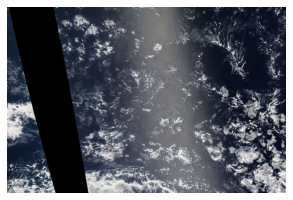

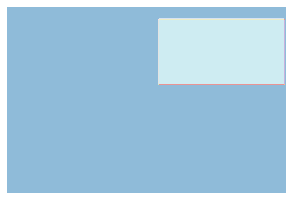

In [21]:
i = 90
dsets.train[i][0].show(), dsets.train[i][1].show()

In [23]:
dls = dblock.dataloaders(df_train_fish)

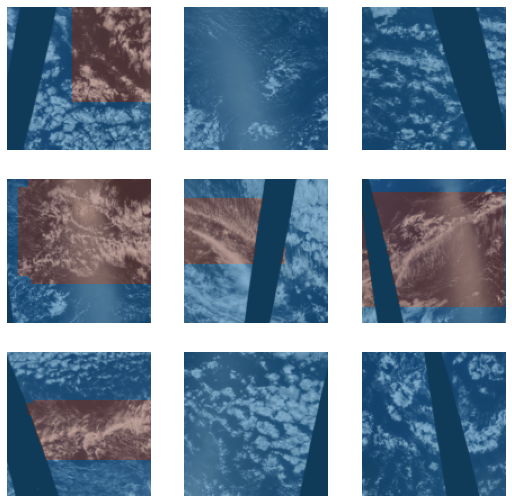

In [24]:
dls.show_batch(nrows=3, ncols=3)

In [25]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,time
0,0.448904,0.392516,01:45


epoch,train_loss,valid_loss,time
0,0.376288,0.367931,02:00
1,0.363614,0.354831,01:41
2,0.351738,0.361064,01:42
3,0.333678,0.351368,01:44
4,0.314923,0.344610,01:46
5,0.296575,0.349989,01:44


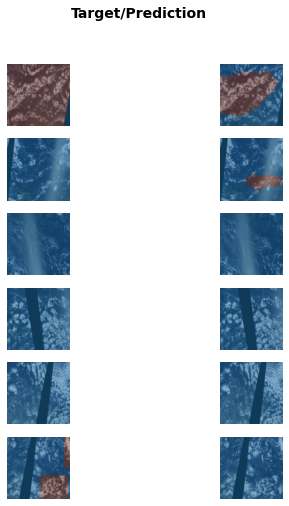

In [26]:
learn.show_results(max_n=6, figsize=(7,8))

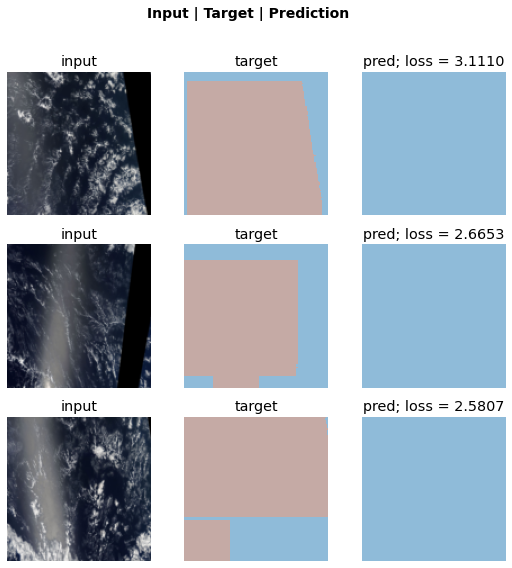

In [27]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)